<a href="https://colab.research.google.com/github/qmffkem/learning-micrograd/blob/main/JaeungJang.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Starting to watch video "The spelled-out intro to neural networks and backpropagation: building micrograd" by Andreyj Karpathy.
Link: https://www.youtube.com/watch?v=VMj-3S1tku0

Thanks, Wills for setting this up and thank you everyone who is on the same journey to take this course together! Glad to meet you all. I am farely new to neural networks and any of AI related topics and hope to learn a lot from you all! :)

# 4/13/2024

# Overview
Link:https://www.youtube.com/watch?v=VMj-3S1tku0&t=25s


micrograd: tiny autograd engine

autograd: automatic gradient(?) -> this does backpropagation...

backpropagation: algorithm to efficiently evaluate the gradient of some kind of loss function respect to the weights of neural network

  -> This allows to iteratively tune the weights of the neural network to minimize the loss function and therefore improve the acuracy of the network


---

**Link to micrograd**:https://github.com/karpathy/micrograd

Things defined:
* neuron
* layer
* MLP: multi-layer perceptron == sequence of layers of neurons



# Derivative of a simple function with one input

Link:https://www.youtube.com/watch?v=VMj-3S1tku0&t=488s



---



In [84]:
import math
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

In [85]:
def f(x):
  return 3*x**2 - 4*x + 5

In [86]:
f(3.0)

20.0

In [87]:
xs = np.arange(-5, 5, 0.25)
xs

array([-5.  , -4.75, -4.5 , -4.25, -4.  , -3.75, -3.5 , -3.25, -3.  ,
       -2.75, -2.5 , -2.25, -2.  , -1.75, -1.5 , -1.25, -1.  , -0.75,
       -0.5 , -0.25,  0.  ,  0.25,  0.5 ,  0.75,  1.  ,  1.25,  1.5 ,
        1.75,  2.  ,  2.25,  2.5 ,  2.75,  3.  ,  3.25,  3.5 ,  3.75,
        4.  ,  4.25,  4.5 ,  4.75])

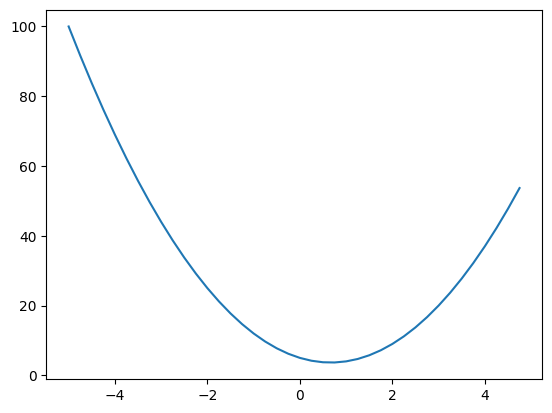

In [88]:
ys = f(xs)
ys
plt.plot(xs, ys)

In [89]:
h = 0.000001
x = 2/3
(f(x + h) - f(x))/h

2.999378523327323e-06

# Derivative of a function with multiple inputs

Link:https://youtu.be/VMj-3S1tku0?t=873




In [90]:
# let's get more complex

a = 2.0
b = -3.0
c = 10.0
d = a*b + c
print(d)

4.0


In [91]:
h = 0.00001

# inputs
a = 2.0
b = -3.0
c = 10.0

d1 = a*b + c
a += h
d2 = a*b + c
print('d1', d1)
print('d2', d2)
print('slope', (d2 - d1)/ h)

d1 4.0
d2 3.9999699999999994
slope -3.000000000064062


In [92]:
h = 0.00001

# inputs
a = 2.0
b = -3.0
c = 10.0

d1 = a*b + c
b += h
d2 = a*b + c
print('d1', d1)
print('d2', d2)
print('slope', (d2 - d1)/ h)

d1 4.0
d2 4.00002
slope 2.0000000000131024


In [93]:
h = 0.00001

# inputs
a = 2.0
b = -3.0
c = 10.0

d1 = a*b + c
c += h
d2 = a*b + c
print('d1', d1)
print('d2', d2)
print('slope', (d2 - d1)/ h)

d1 4.0
d2 4.00001
slope 0.9999999999621422


# 4/14/2024

## Starting the core Value object of micrograd and its visualization

Link:https://youtu.be/VMj-3S1tku0?t=1154

### Value class

In [94]:
class Value:
  def __init__(self, data, _children=(), _op='', label=''):
    self.data = data
    self.grad = 0.0 # 0 means no effect;
    self._backward = lambda: None  # case for leaf node; there is nothing to do
    self._prev = set(_children)
    self._op = _op
    self.label = label


  def __repr__(self):
    return f"Value(data={self.data})"

  def __add__(self, other): # self * other
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data + other.data, (self, other), "+")

    def _backward():
      self.grad += 1.0 * out.grad
      other.grad += 1.0 * out.grad
    out._backward = _backward
    return out

  def __radd__(self, other):
    return self + other

  def __mul__(self, other): # self * other
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data * other.data, (self, other), "*")

    def _backward():
      self.grad += other.data * out.grad
      other.grad += self.data * out.grad
    out._backward = _backward
    return out

  def __rmul__(self, other):
    return self * other

  def __pow__(self, other):
    assert isinstance(other, (int, float)), "only supporting int/float powers for now"
    out = Value(self.data**other, (self,), f'**{other}')

    def _backward():
      self.grad += other * (self.data**(other - 1)) * out.grad
    out._backward = _backward

    return out

  def __truediv__(self, other): # self / other
    return self * other**-1

  def __neg__(self): # -self
    return self * -1

  def __sub__(self, other): # self - other
    return self + (-other)

  def tanh(self):
    x = self.data
    t = (math.exp(2*x) - 1) / (math.exp(2*x) + 1)
    out = Value(t, (self, ), 'tanh')

    def _backward():
      self.grad += (1 - t**2) * out.grad
    out._backward = _backward
    return out

  def exp(self):
    x = self.data
    out = Value(math.exp(x), (self, ), 'exp')

    def _backward():
      print(self)
      self.grad += out.data * out.grad
    out._backward = _backward

    return out

  def backward(self):

    topo = []
    visited = set()
    def build_topo(v):
      if v not in visited:
        visited.add(v)
        for child in v._prev:
          build_topo(child)
        topo.append(v)
    build_topo(self)

    self.grad = 1.0
    for node in reversed(topo):
      node._backward()


With children, I can keep track of which values were used to create the current value, and with op, I know which operation was used to generate the current data with the children.

He mentioned that the reason for using set is for the performance optimization.

In [95]:
from graphviz import Digraph

def trace(root):
  # builds a set of all nodes and edges in a graph
  nodes, edges = set(), set()
  def build(v):
    if v not in nodes:
      nodes.add(v)
      for child in v._prev:
        edges.add((child, v))
        build(child)
  build(root)
  return nodes, edges

def draw_dot(root):
  dot = Digraph(format='svg', graph_attr={'rankdir': "LR"}) # LR = left to right

  nodes, edges = trace(root)
  for n in nodes:
    uid = str(id(n))
    #  for any value in the graph, create a rectangular ('record') node for it
    dot.node(name = uid, label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
    if n._op:
      # if this value is a result of some operation, create an op node for it
      dot.node(name = uid + n._op, label = n._op)
      # and connect this node to it
      dot.edge(uid + n._op, uid)
  for n1, n2 in edges:
    # connect n1 to the op node of n2
    dot.edge(str(id(n1)), str(id(n2)) + n2._op)

  return dot

In [96]:
def lol():
  h = 0.001


  a = Value(2.0, label='a')
  b = Value(-3.0, label='b')
  c = Value(10.0, label='c')
  e = a * b; e.label = 'e'
  d = e + c; d.label = 'd'
  f = Value(-2.0, label='f')
  L = d * f; L.label = 'L'
  L1 = L.data

  a = Value(2.0, label='a')
  b = Value(-3.0, label='b')
  c = Value(10.0, label='c')
  e = a * b; e.label = 'e'
  d = e + c; d.label = 'd'
  f = Value(-2.0, label='f')
  L = d * f; L.label = 'L'
  L2 = L.data

  print((L2 - L1)/h)

lol()

0.0


# 4/15/2024

## manual backpropagation example \#1: simple expression

This sets up the grad manually.
Since there is no change on derivate of L respect to L, we set 1 to it.

for **d** and **f** they become each other after derivative using manual calculation and by testing with by injecting the value.

In [97]:
# manually setting it up here
# L.grad = 1.0

# L = d * f        # based on the expression expression above.
                 # if taking derivative on d, grad = f; if on f, grad = d
# d.grad = -2.0
# f.grad = 4.0

In [98]:
# draw_dot(L)

# 4/16/2024


covering how to calculate derivate L respecte to c, and derivative of L respect to e.

This is a bit more comprex than the previous example of d and f.

dd / dc = 1.0

dd / de = 1.0

d = c + e

we want to know how L is affected by the change of c and change of e; derivative of L respect to c and derivate of L respect to e.

we know the local derivative; dL/dd and dL/df from above.

now we know the local derivate as well; dd/dc and dd/de.

what we need here to find the dL/dc or dL/de is the **chain rule**.


**want:**
dL / dc = (dL / dd) * (dd / dc)

**know:**
dL / dd
dd / dc


In [99]:
# c.grad = -2.0
# e.grad = -2.0


In [100]:
# draw_dot(L)

dL / de = -2.0

dL / da = (dL / de) * (de / da)\
        = (-2.0) * (-3.0)\
        = 6.0

dL / db = (dL / de) * (de / db)\
        = (-2.0) * (2.0)\
        = -4.0

In [101]:
# a.grad = -2.0 * -3.0
# b.grad = -2.0 * 2.0

In [102]:
# draw_dot(L)

## preview of a single optimixation step

if we want to increase value of L up, we increase the leaf node to the direction of gradient.

In [103]:
# a.data += 0.01 * a.grad
# b.data += 0.01 * b.grad
# c.data += 0.01 * c.grad
# f.data += 0.01 * f.grad

# e = a * b
# d = e + c
# L = f * d

In [104]:
# print(L.data)

## manual backpropagation example \#2: a neuron

In [105]:
# inputs x1, x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,s2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1w1'
x2w2 = x2*w2; x2w2.label = 'x2w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'

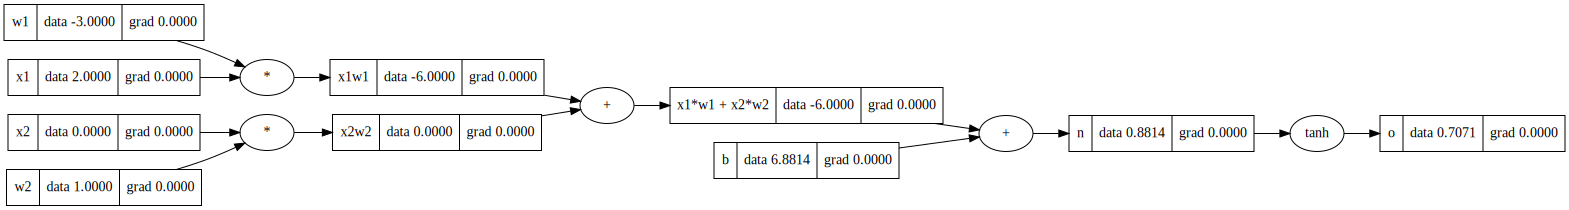

In [106]:
draw_dot(o)

how we just built a single neuron and going to manually feed and set the backpropagation.


In [107]:
o.grad = 1.0
# do/dn = 1 - tanh**2 = 1 - o**2 ; the equation is from wikipedia
n.grad = 0.5

b.grad = 0.5
x1w1x2w2.grad = 0.5

x1w1.grad = 0.5
x2w2.grad = 0.5

x2.grad = w2.data * x2w2.grad
w2.grad = x2.data * x2w2.grad

x1.grad = w1.data * x1w1.grad
w1.grad = x1.data * x1w1.grad

## implementing the backward function for each operation

implemented the logic to perform the manual backpropagation to the **Value** class in a code and run the _backward() function to set the gradient now.

In [108]:
o.grad = 1.0

In [109]:
o._backward()
n._backward()
b._backward()
x1w1x2w2._backward()
x1w1._backward()
x2w2._backward()

## implementing the backward function for a whole expression gpaph

the backward fucntion need to be called from the root node and then the childrens follow.

to perform the backward function this order, he implements topological sort, set base case, and call the function with root node.

In [110]:
o.grad = 1.0

topo = []
visited = set()
def build_topo(v):
  if v not in visited:
    visited.add(v)
  for child in v._prev:
    build_topo(child)
  topo.append(v)

build_topo(o)

for node in reversed(topo):
  node._backward()

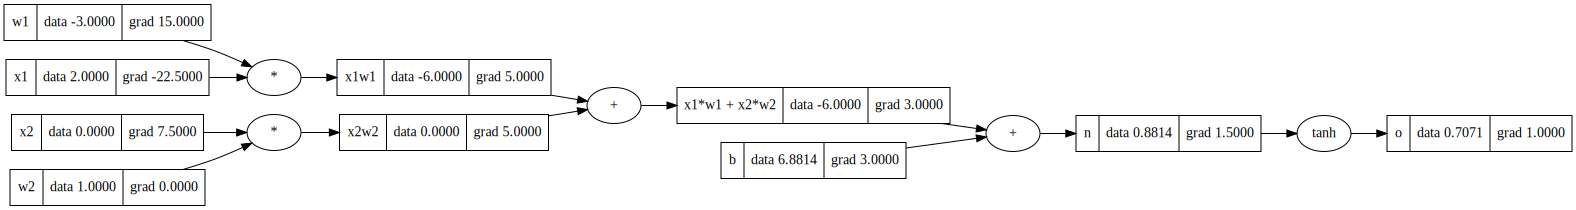

In [111]:
draw_dot(o)

In [112]:
o.backward()

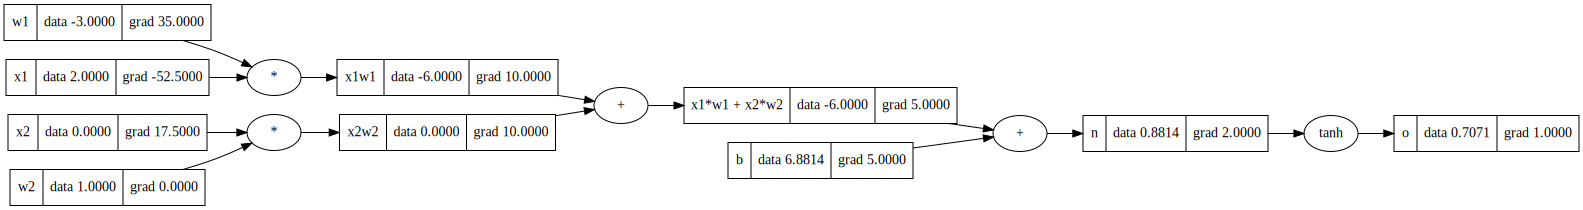

In [113]:
draw_dot(o)

# 4/17/2024

## fixing a backprop bug when one node is used multiple times

There is an error on the gradient when a value is used more than once.
In the below example for b = a + a,
we know that the derivative of the function is 2, but the gradient is 1. The reason is because the value is overriden when it was used more than once.

Therefore, based on the **multivariable case** of the derivative, the derivatives are kept added, instead of set.

This is the minor change covered on this section.

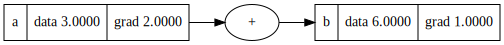

In [114]:
a = Value(3.0, label='a')
b = a + a ; b.label = 'b'
b.backward()
draw_dot(b)

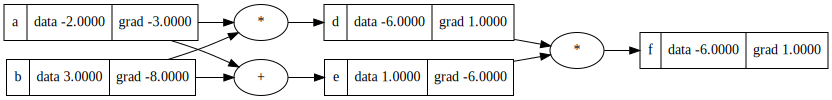

In [115]:
a = Value(-2.0, label='a')
b = Value(3.0, label='b')
d = a * b ; d.label = 'd'
e = a + b ; e.label = 'e'
f = d * e ; f.label = 'f'

f.backward()

draw_dot(f)

## breaking up a tanh, exercising with more operations

In [116]:
# copy from above

# inputs x1, x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,s2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1w1'
x2w2 = x2*w2; x2w2.label = 'x2w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'

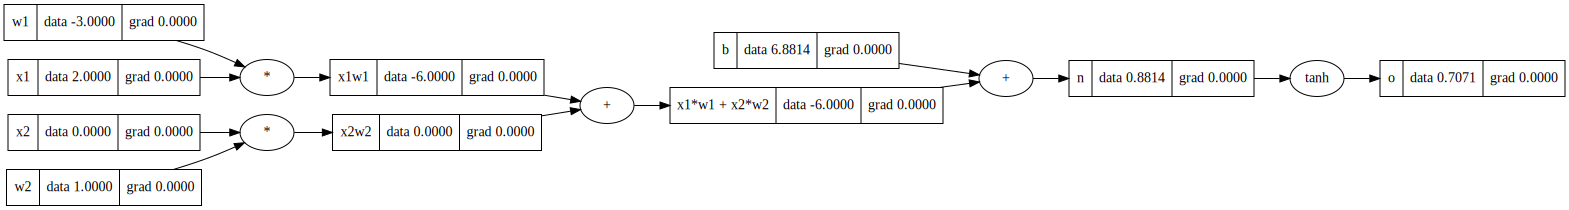

In [117]:
draw_dot(o)

In [118]:
a = Value(2.0)
a * 2

Value(data=4.0)

what's explained here is that the example of adding int object to Value object. Initial implementation did not handle this case, so we added a case that sets **other** to be other if it is an instance of Value, else wrap it with Value.
This does not handle the case for string or other type, but for the sake of simplicity it might be okay...

then the interesting concept of python came up; a function called **\_\_rmul\_\_**
when you call `a + b`, this is equavalent to a.\_\_add\_\_(b). if a is a generic python type like int, it cannot handle my own class; thus throwing an error.

what rmul does is that in the case of this error, if my own instance has this function defined, it is called instead.

In [119]:
3 + a

Value(data=5.0)

In [120]:
a.exp()

Value(data=7.38905609893065)

In [121]:
a = Value(2.0)
b = Value(4.0)
a / b

Value(data=0.5)

In [122]:
a - b

Value(data=-2.0)

In [123]:
# copy from above

# inputs x1, x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,s2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
o = n.tanh(); o.label = 'o'
o.backward()

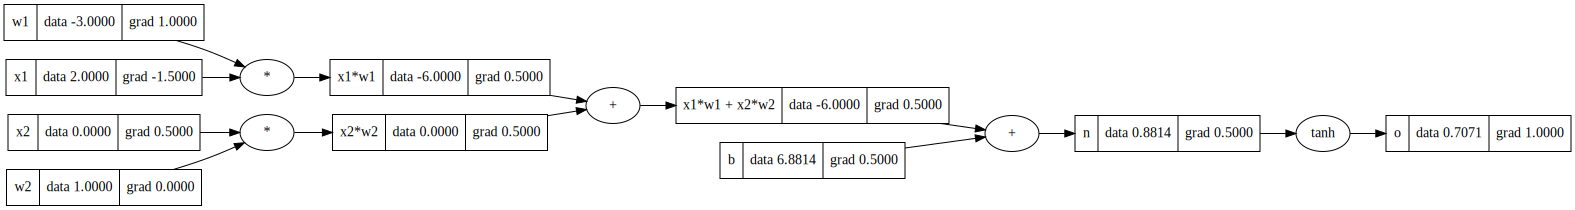

In [124]:
draw_dot(o)

Value(data=1.7627471740390863)


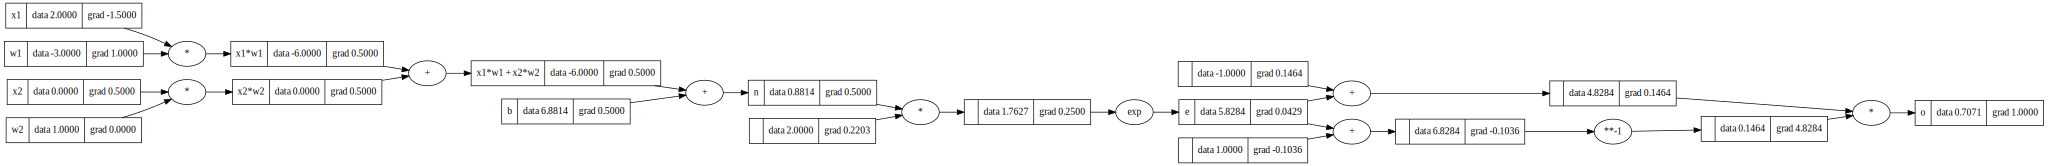

In [125]:
# copy from above

# inputs x1, x2
x1 = Value(2.0, label='x1')
x2 = Value(0.0, label='x2')
# weights w1,s2
w1 = Value(-3.0, label='w1')
w2 = Value(1.0, label='w2')
# bias of the neuron
b = Value(6.8813735870195432, label='b')
# x1*w1 + x2*w2 + b
x1w1 = x1*w1; x1w1.label = 'x1*w1'
x2w2 = x2*w2; x2w2.label = 'x2*w2'
x1w1x2w2 = x1w1 + x2w2; x1w1x2w2.label = 'x1*w1 + x2*w2'
n = x1w1x2w2 + b; n.label = 'n'
# ---------
e = (2*n).exp() ; e.label = 'e'
o = (e - 1) / (e + 1)
# ---------
o.label = 'o'
o.backward()
draw_dot(o)

# 4/18/2024

## doing the same thing but in PyTorch

micrograd is scalar, pytorch is tensor based.
Tensor is n dimentional array

* calling double function to convert default float32 value to float64 for higher precision

In [126]:
import torch

x1 = torch.Tensor([2.0]).double() ; x1.requires_grad = True
x2 = torch.Tensor([0.0]).double() ; x2.requires_grad = True
w1 = torch.Tensor([-3.0]).double() ; w1.requires_grad = True
w2 = torch.Tensor([1.0]).double() ; w2.requires_grad = True
b = torch.Tensor([6.8813735870195432]).double() ; b.requires_grad = True
n = x1*w1 + x2*w2 + b
o = torch.tanh(n)

print(o.data.item())
o.backward()

print('---')
print('x2', x2.grad.item())
print('w2', w2.grad.item())
print('x1', x1.grad.item())
print('w1', w1.grad.item())

0.7071066904050358
---
x2 0.5000001283844369
w2 0.0
x1 -1.5000003851533106
w1 1.0000002567688737


as we see above, the forward check, o = 0.7071 match with value above,
and also the backward check agrees with the value above as well.

What was built for the micrograd is same as pytorch, but it has more features and efficient then the micrograd.

## Building out a neural net library (multi-layer perceptron) in micrograd

"neural net is just a specific class of mathemetical expression"

### Neuron, Layer, MLP classes

In [127]:
import random

In [247]:
class Neuron:
  def __init__(self, nin):                                        # number of inputs for this neuron
    self.w = [Value(random.uniform(-1,1)) for _ in range(nin)]    # create weight for each input
    self.b = Value(random.uniform(-1,1))                          # bias that controls overall happiness of the neuron

  def __call__(self, x):
    # w * x + b
    act = sum((wi*xi for wi, xi in zip(self.w, x)), self.b)   # dot product
    out = act.tanh()
    return out

  def parameters(self):
    return self.w + [self.b]
#--------------------------------------------------------

class Layer:
  def __init__(self, nin, nout):
    self.neurons = [Neuron(nin) for _ in range(nout)]

  def __call__(self, x):
    outs = [n(x) for n in self.neurons]
    return outs[0] if len(outs) == 1 else outs

  def parameters(self):
    return [p for neuron in self.neurons for p in neuron.parameters()]

    # params = []
    # for neuron in self.neurons:
    #   ps = neuron.parameters()
    #   params.extend(ps)
    # return params

#--------------------------------------------------------

class MLP:
  def __init__(self, nin, nouts):
    sz = [nin] + nouts
    self.layers = [Layer(sz[i], sz[i+1]) for i in range(len(nouts))]

  def __call__(self, x):
    for layer in self.layers:
      x = layer(x)
    return x

  def parameters(self):
    return [p for layer in self.layers for p in layer.parameters()]


# x = [2.0, 3.0, -1.0]     # input
# n = MLP(3, [4, 4, 1])    # 3 inputs, 2 layers of 4 neurons and 1 layer of output with 1 neuron
# n(x)

In [254]:
x = [2.0, 3.0, -1.0]     # input
n = MLP(3, [4, 4, 1])    # 3 inputs, 2 layers of 4 neurons and 1 layer of output with 1 neuron
n(x)

Value(data=0.7379144944743825)

In [255]:
n.parameters()
print(len(n.parameters()))

41


In [145]:
# draw_dot(n(x))

## creating a tiny dataset, writing the loss function

In [256]:
xs = [                             # 4 possible input set
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0],
]

ys = [1.0, -1.0, -1.0, 1.0]        # 4 desired targets

ypred = [ n(x) for x in xs ]
ypred

[Value(data=0.7379144944743825),
 Value(data=0.0461656645543871),
 Value(data=0.9518595268764903),
 Value(data=0.7268353410578615)]

as we see above, we want the 1st output to be higher,\
2nd to be lower,\
3rd to be lower,\
4th to be higher, based on the desired targets. \

we want to calculate a single number measuring the total performance of the neural net; this is called **loss**.

Because the output is not close to the desired target, we can intuitively know that the loss is high and we want to minimize it

In [260]:

# ygt = y ground truth
# yout = y output

# calculating mean square loss value
loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))
loss

Value(data=5.047525953452632)

In [180]:
# draw_dot(loss)

In [258]:
loss.backward()

In [259]:
n.layers[0].neurons[0].w[0].grad

0.38597671738231776

Because the gradient at this specific weight at this neuron at this layer is negative (currently), that the influent of this weight on loss is also negative.

 This means, increasing of this weight influent the loss to go down

In [170]:
# draw_dot(loss)

## colecting all of the parameters of the neural net

adding parameters function into Neurons, Layer, and MLP classes to gather all the weights in one place

In [177]:
n.parameters()
print(len(n.parameters()))

41


## doing gradient optimization manually, training the network

In [222]:
print(n.layers[0].neurons[0].w[0].data)
print(n.layers[0].neurons[0].w[0].grad)

0.46604579200270124
-0.8186674868204185


Same for this case:
the current value for grad is -, so increasing of the value influent loss to go down.



In [244]:
for p in n.parameters():
  p.data += -0.01 * p.grad

In [245]:
print(n.layers[0].neurons[0].w[0].data)
print(n.layers[0].neurons[0].w[0].grad)

0.5929920763000964
-2.603055469944144


In [261]:
ypred = [ n(x) for x in xs ]
ypred
loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))
loss

Value(data=5.047525953452632)

In [304]:
ypred = [ n(x) for x in xs ]
ypred
loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))
loss

Value(data=0.005924123742891557)

In [305]:
loss.backward()

In [306]:
for p in n.parameters():
  p.data += -0.01 * p.grad

In [307]:
ypred

[Value(data=0.993280249243025),
 Value(data=-0.9579432855195636),
 Value(data=-0.9362551534170714),
 Value(data=0.9931592402552313)]

In [309]:
# n.parameters()

In [322]:
# re-initializing neural network

x = [2.0, 3.0, -1.0]     # input
n = MLP(3, [4, 4, 1])    # 3 inputs, 2 layers of 4 neurons and 1 layer of output with 1 neuron
n(x)

Value(data=-0.9439070401025821)

In [323]:
# data

xs = [                             # 4 possible input set
    [2.0, 3.0, -1.0],
    [3.0, -1.0, 0.5],
    [0.5, 1.0, 1.0],
    [1.0, 1.0, -1.0],
]

ys = [1.0, -1.0, -1.0, 1.0]        # 4 desired targets

In [350]:
# above is the manual stepping to to find the best model by running forward pass, backward pass and steping.

# below is updating several times
for k in range(20):

  # forward pass
  ypred = [ n(x) for x in xs ]
  loss = sum((yout - ygt)**2 for ygt, yout in zip(ys, ypred))

  # backward pass
  for p in n.parameters():    # zero grad whenever it runs as we are keep adding grad
    p.grad = 0.0
  loss.backward()

  # update
  for p in n.parameters():
    p.data += -0.05 * p.grad

  print(k, loss.data)

0 0.002690579375055359
1 0.0026786169948798877
2 0.00266675282691779
3 0.0026549857112240583
4 0.002643314505636053
5 0.002631738085439048
6 0.002620255343039489
7 0.002608865187645171
8 0.0025975665449528016
9 0.002586358356842245
10 0.002575239581077416
11 0.0025642091910139733
12 0.0025532661753131
13 0.0025424095376616203
14 0.002531638296498269
15 0.002520951484745594
16 0.0025103481495478944
17 0.002499827352014649
18 0.0024893881669693953
19 0.0024790296827040307


In [351]:
ypred

[Value(data=0.9799429270386676),
 Value(data=-0.9860013390086063),
 Value(data=-0.9694454451175294),
 Value(data=0.9692233826857151)]

## summary of what we learned, how to go towards modern neural nets

neural net: mathematical expressions that take input as a data, that uses weight and parameters passed to mathematical expression for forward pass, which followed by a loss function that calculate accuracy of the prediction, then backward pass to tune the parameters in the case it does not work as we wanted.

lower loss means better and follows prediction.